In [1]:
import networkx as nx
import matplotlib.pyplot as plt
#using this to ensure we dont cut off the edges in the graph
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
import pandas as pd
import scipy
import xlsxwriter

In [2]:
#todo
## Redo the graph with phrases and stop word removal

In [3]:
df = pd.read_csv('basic_pos.csv',converters={'phrase': pd.eval,
                                             'nsubjects':pd.eval,
                                             'dobjects':pd.eval,
                                            'nouns':pd.eval,
                                            'subjects':pd.eval,
                                            'objects':pd.eval})

In [4]:
df.replace('cid:127','', inplace=True)
df.replace('\x0c','',inplace=True)

In [5]:
nouns = df[['nouns','sent']]
nouns['nouns2'] = df.nouns
for c in ['nouns','nouns2']:
    nouns = nouns.explode(c)
nouns = nouns.drop_duplicates()
deduped_relationships = []
for sent in nouns.sent.unique():
    df = nouns[nouns.sent==sent]
    sorted_relationships = [sorted(x) for x in list(zip(df['nouns'],df['nouns2']))]
    for sr in sorted_relationships:
        if sr not in deduped_relationships:
            sr.append(sent)
            deduped_relationships.append(sr)

C:\Users\kelly\AppData\Local\Temp\ipykernel_11804\2837264446.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nouns['nouns2'] = df.nouns


In [65]:
graph_df = pd.DataFrame(deduped_relationships, columns=['noun1','noun2','sent'])
graph_df = graph_df[graph_df.noun1 != graph_df.noun2]
graph_df = graph_df.drop_duplicates()
graph_df.dropna(how='any', inplace=True)
graph_df.sort_values(by = ['sent','noun1','noun2'], inplace=True)
graph_df.to_csv('graph_df.csv')

In [66]:
graph= nx.from_pandas_edgelist(graph_df, 'noun1', 'noun2', edge_attr='sent', 
                             create_using=nx.MultiGraph())
plt.figure(figsize=(50,20))
nx.draw(graph,font_size=12,pos=nx.random_layout(graph),node_size=100)
plt.savefig(f"full_graph.jpeg", format="jpeg")
plt.clf()

C:\Users\kelly\AppData\Local\Temp\ipykernel_11804\3043172069.py:5: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f"full_graph.jpeg", format="jpeg")
C:\Users\kelly\AppData\Local\Temp\ipykernel_11804\3043172069.py:5: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f"full_graph.jpeg", format="jpeg")


<Figure size 5000x2000 with 0 Axes>

In [67]:
graph.number_of_edges('steering','drive')

0

In [8]:
#To Do
#count the number of paths.  

In [9]:
# Power Steering and 4 Wheel Drive

In [138]:
def compute_connections(graph, source, target, weight=None, n=3):
    shortest_path = nx.shortest_path(graph, source=source, target=target, weight=weight, method='dijkstra')
    all_shortest_paths = nx.all_shortest_paths(graph,source=source, target=target, weight=weight, method='dijkstra')
    all_paths = nx.all_simple_paths(graph, source=source, target=target, cutoff=n)
    return shortest_path, all_shortest_paths, all_paths

def draw_shortest_paths(graph, generator, source, target, name='all_shortest_paths'):
    out_graph = nx.MultiGraph()
    path_list = []
    for p in generator:
        out_graph.update(graph.subgraph(p))
        path_list.append(p)
    nx.draw(out_graph,with_labels=True,font_size=12,pos=nx.bipartite_layout(out_graph, nodes=[source, target]))
    #nx.write_gexf(graph, f'{name}.gexf')
    plt.savefig(f"{name}.jpeg", format="jpeg")
    return path_list, out_graph

def draw_all_paths(graph, generator, source, target, name='all_paths'):
    out_graph = nx.MultiGraph()
    path_list = [] 
    for p in generator:
        out_graph.update(graph.subgraph(p))
        path_list.append(p)
    plt.figure(figsize=(20,20))
    nx.draw(out_graph,with_labels=True,font_size=12)
    # nx.write_gexf(graph, f'{name}.gexf')
    plt.savefig(f"{name}.jpeg", format="jpeg")
    return path_list,out_graph

def draw_one_half_hop(graph,source):
    node_neighbors = list(nx.neighbors(graph,source))
    node_neighbors.append(source)
    out_graph=nx.induced_subgraph(graph,node_neighbors)
    plt.figure(figsize=(10,10))
    nx.draw(out_graph,with_labels=True,font_size=12)
    #nx.write_gexf(graph, f'{name}.gexf')
    name=f"one_hop_{source}"
    plt.savefig(f"{name}.jpeg", format="jpeg")
    path_list = out_graph.edges()
    return path_list,out_graph

def draw_one_hop(graph,source):
    edges = graph.edges(source, data=True)
    out_graph=nx.MultiGraph(edges)
    plt.figure(figsize=(10,20))
    nx.draw(out_graph,with_labels=True,font_size=18,pos=nx.bipartite_layout(out_graph, nodes=[source]))
    #nx.write_gexf(graph, f'{name}.gexf')
    name=f"one_hop_{source}"
    plt.savefig(f"{name}.jpeg", format="jpeg")
    path_list = out_graph.edges()
    return path_list,out_graph

def make_sentence_df(subgraph):
    edge_data = subgraph.edges(data=True)
    edge_data = pd.DataFrame(list(edge_data), columns = ['noun','noun2','sentence'])
    edge_data.sentence = edge_data.sentence.apply(lambda x: ','.join(x.values()))
    edge_data = edge_data.sort_values(by=['noun2','noun'])
    return edge_data

def compute_deg_centrality(graph,n_nodes=10):
    dg_centrality = nx.degree_centrality(graph)
    deg_df = pd.DataFrame.from_dict(dg_centrality, orient='index', columns=['degree_centrality']).sort_values(by='degree_centrality',ascending=False)
    deg_df.reset_index(inplace=True, names='noun')
    deg_df['n_neighbors'] = deg_df.noun.apply(lambda x: len(list(nx.neighbors(graph,x))))
    return deg_df.head(n_nodes)

def save_excel(name, graph, data_frame, path_list):
    writer = pd.ExcelWriter(f'{name}.xlsx', engine='xlsxwriter')
    workbook  = writer.book
    image = workbook.add_worksheet(name='network_graph')
    image.insert_image('B2', f'{name}.jpeg')
    path_df = pd.DataFrame(path_list).drop_duplicates()
    #adding if else statement to account for excel's datasize limits
    if len(path_df)<1059724:
        path_df.to_excel(writer,'paths', index=False, header=False)
    else:
        paths = workbook.add_worksheet(name='paths')
        paths.write(0,0,'to many paths to export')
    compute_deg_centrality(graph).to_excel(writer,'degree_centrality',index=False)
    if len(data_frame)<1059724:
        data_frame.to_excel(writer, sheet_name='data', index=False)
    else:
        sents = workbook.add_worksheet(name='data')
        sents.write(0,0,'to many paths to export')
    workbook.close()

C:\Users\kelly\AppData\Local\Temp\ipykernel_11804\1835221776.py:15: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f"{name}.jpeg", format="jpeg")
C:\Users\kelly\AppData\Local\Temp\ipykernel_11804\1835221776.py:15: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f"{name}.jpeg", format="jpeg")
C:\Users\kelly\AppData\Local\Temp\ipykernel_11804\1835221776.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f"{name}.jpeg", format="jpeg")
C:\Users\kelly\AppData\Local\Temp\ipykernel_11804\1835221776.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f"{name}.jpeg", format="jpeg")
C:\Users\kelly\AppData\Local\Temp\ipykernel_11804\1835221776.py:27: UserWarning: This figure inc

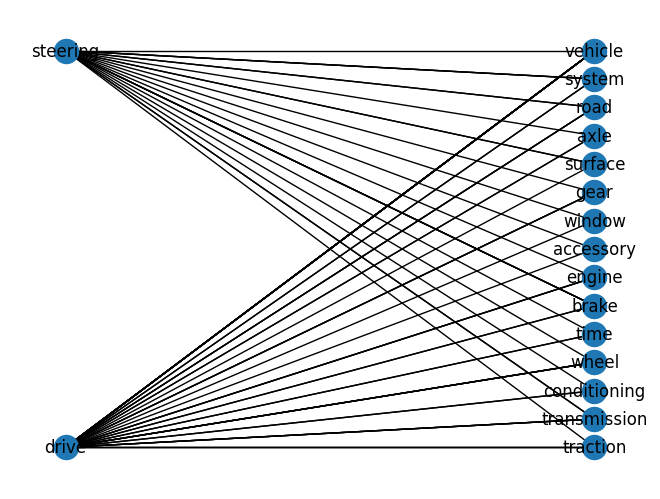

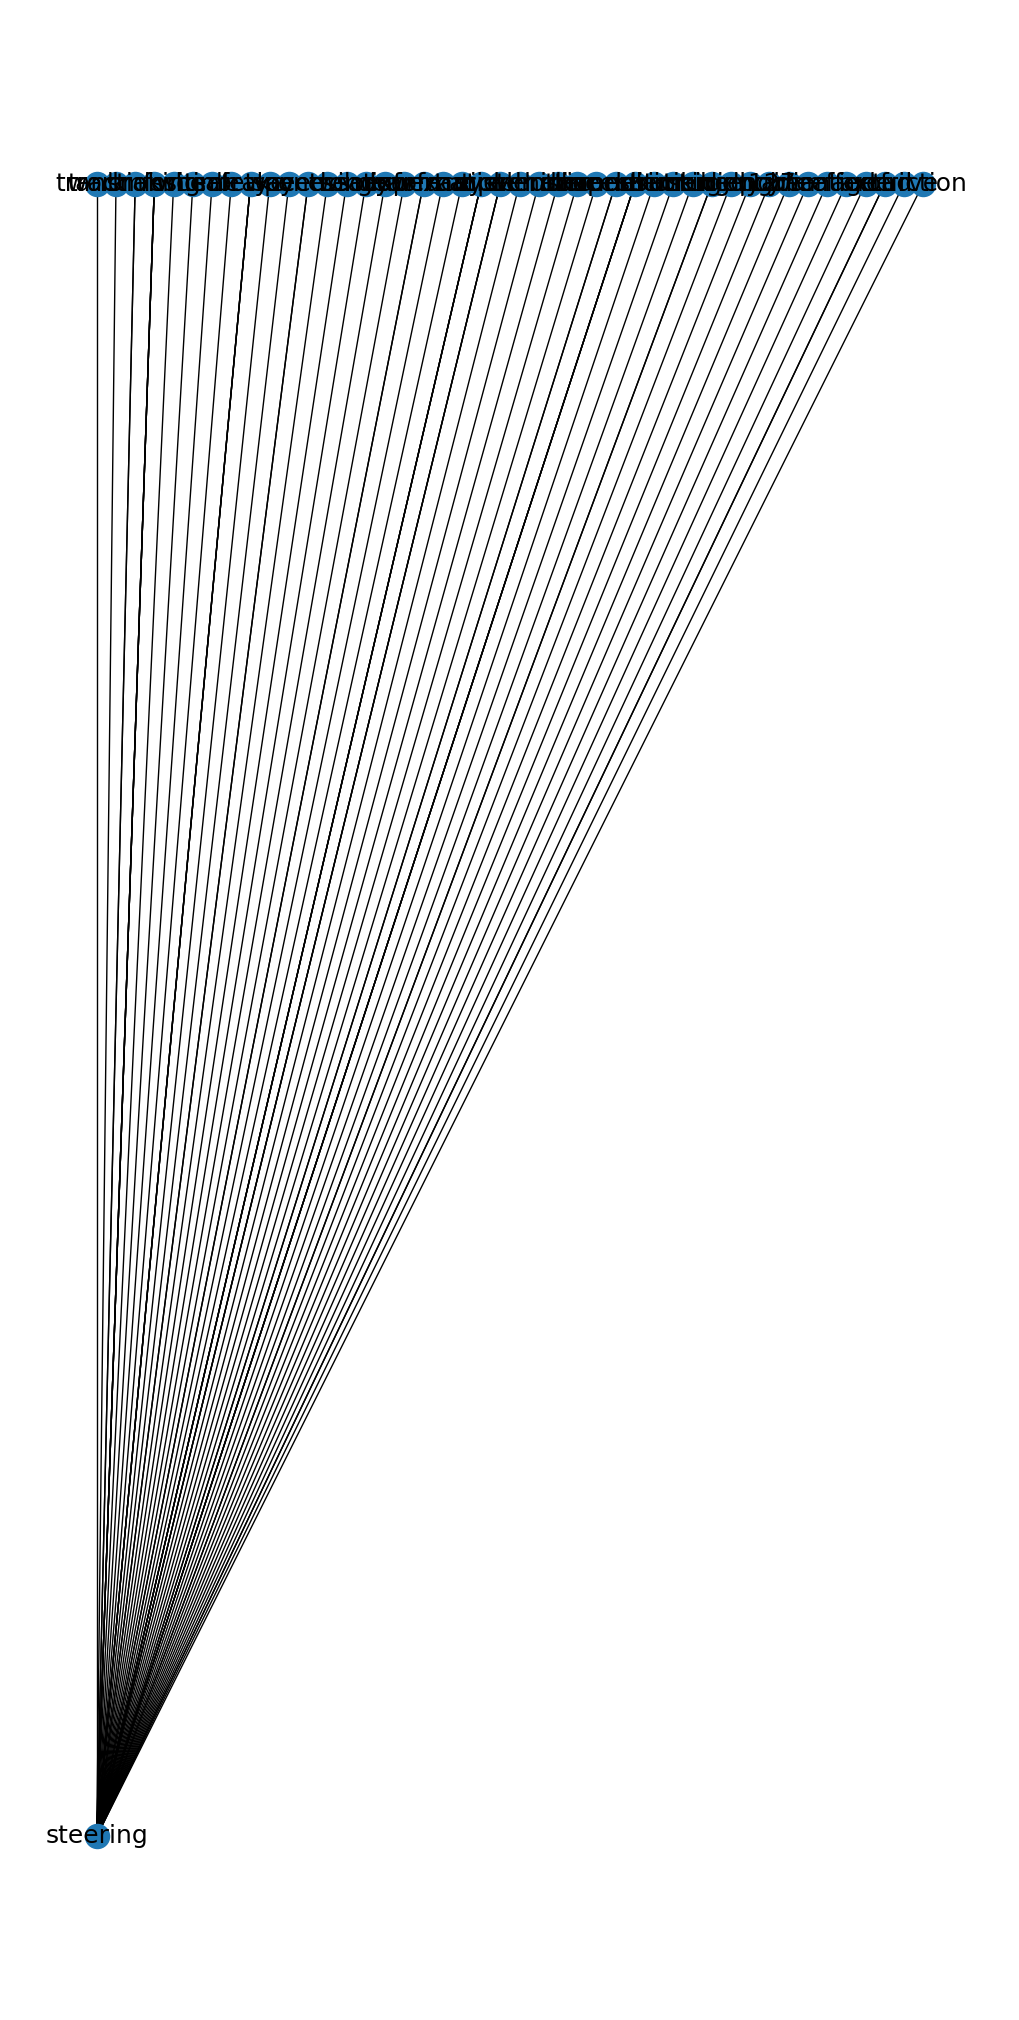

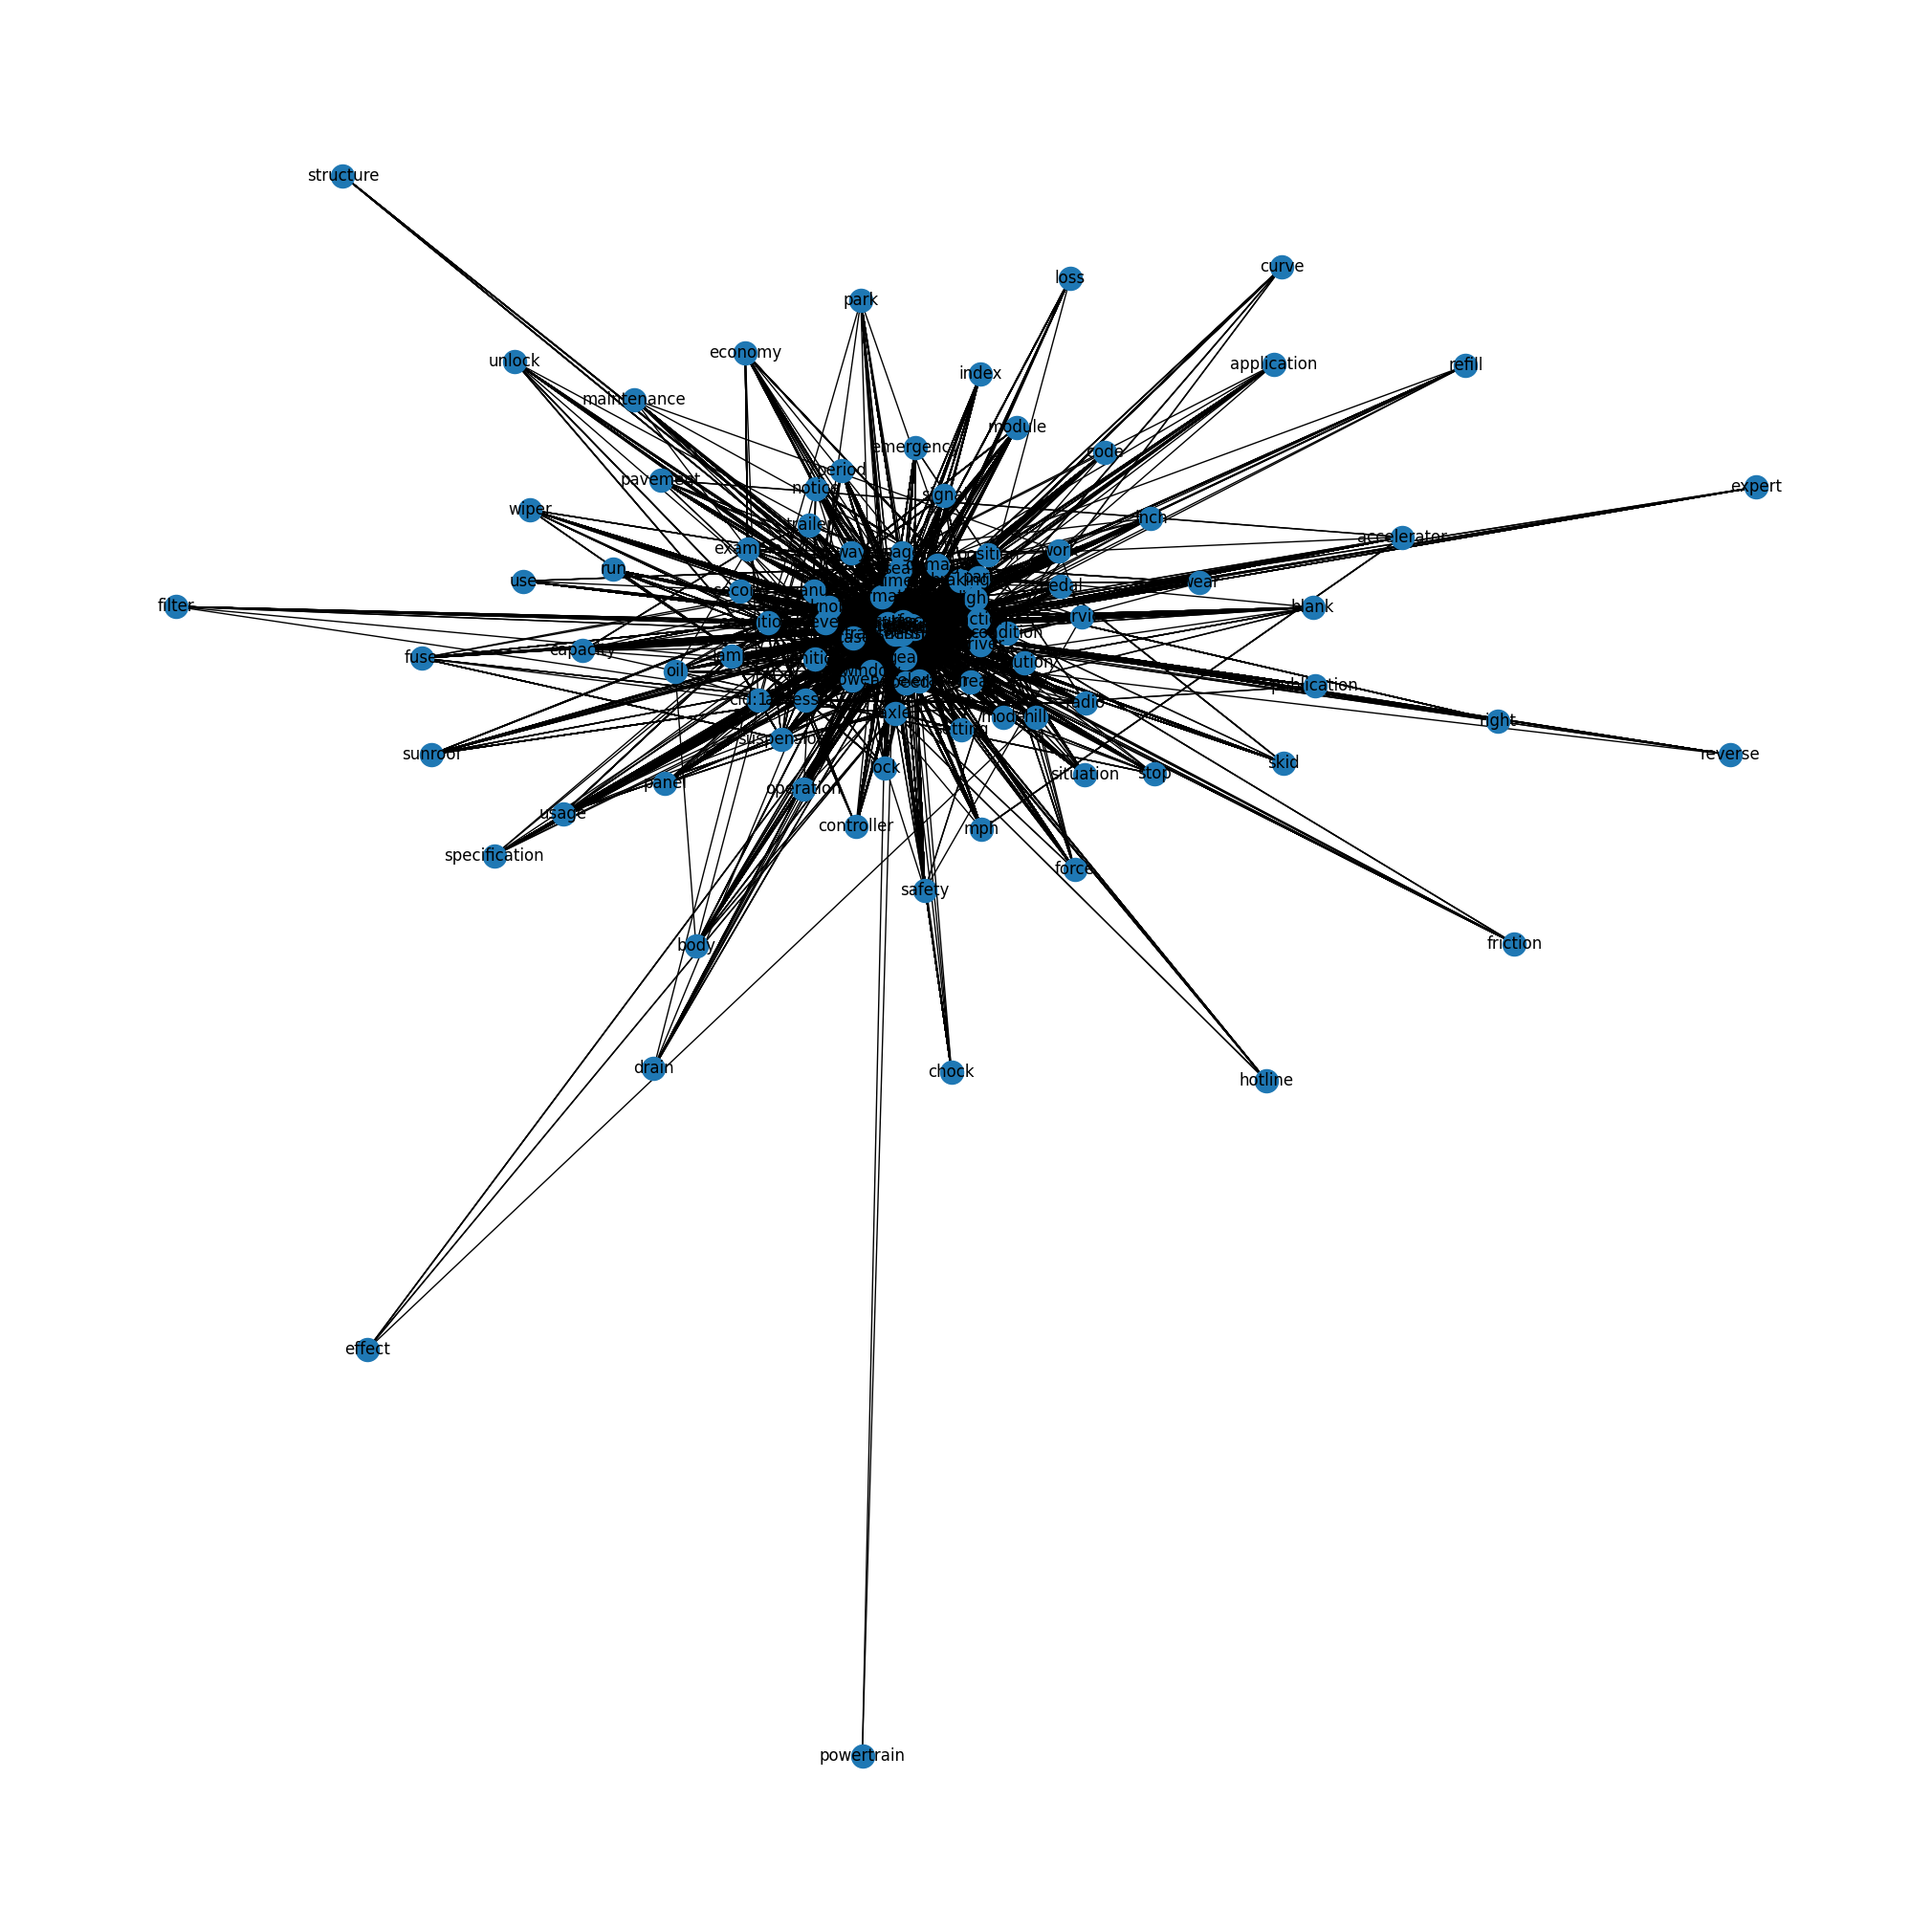

In [133]:
source, target = 'steering','drive'
#run networkx calculations
shortest_path, all_shortest_paths, all_paths = compute_connections(graph=graph, source=source, target=target, n=3)
#save shortest paths
shortest_path_list, shortest_path_graph = draw_shortest_paths(graph=graph, generator=all_shortest_paths, source=source, target=target)
shortest_path_df = make_sentence_df(shortest_path_graph)
save_excel(name = 'all_shortest_paths', graph=shortest_path_graph, data_frame=shortest_path_df,path_list=shortest_path_list)
#save one hop
one_hop_path_list,one_hop_graph = draw_one_hop(graph=graph, source=source)
one_hop_df=make_sentence_df(one_hop_graph)
save_excel(name = f'one_hop_{source}', graph=one_hop_graph, data_frame=one_hop_df, path_list=one_hop_path_list)
#save all paths
all_path_list, all_path_graph = draw_all_paths(graph=graph, generator=all_paths, source=source, target=target)
all_path_df = make_sentence_df(all_path_graph)
save_excel(name = 'all_paths',graph=all_path_graph, data_frame=all_path_df, path_list=all_path_list)

In [140]:
compute_deg_centrality(graph,n_nodes=10)

,noun,degree_centrality,n_neighbors
0,vehicle,1.782274,687
1,system,0.657033,347
2,button,0.535645,227
3,tire,0.396275,253
4,engine,0.322415,223
5,position,0.282595,177
6,display,0.281310,130
7,information,0.278741,199
8,control,0.267823,198
9,light,0.262042,169


# Insights
## Power Steering and 4wheel Drive
1) There is no direct connection between powersteering and 4wheeldrive.  
2) The are connected by the type of surface you are driving on.  
3) The Transmission and Breaks play a major roll in connecting the two systems across multiple vehicle systems.  
## The Whole Car
1) The tires are the most connected (most important?) part of the system, followed by the engine

# OLD

In [ ]:
simple_df = df[['subjects','objects','sent']]

In [ ]:
simple_df = simple_df[(simple_df.subjects.apply(lambda x: len(x)>0)) & 
                      (simple_df.objects.apply(lambda x: len(x)>0))]

In [ ]:
explode = simple_df.copy()
for c in ['subjects','objects']:
    explode = explode.explode(c)

In [ ]:
explode_df = explode.drop_duplicates()

In [ ]:
explode_df[explode_df['objects']=='steering']